# Automated Feature Engineering with Featuretools

_Automated feature engineering aims to help the data scientist by automatically creating many candidate features out of a dataset from which the best can be selected and used for training._ In this notebook we use [Featuretools](https://docs.featuretools.com/). 

Featuretools which is designed to generate features relational datasets. Let's use Featureools to engineer features from the Home Credit data set.

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from quilt.data.avare import homecredit
import featuretools as ft
import pandas as pd
pd.set_option('display.max_columns', 125)

# Overview: Featuretools

To use Featuretools, we must encode the data types for each table and relationships among the tables. The tables and relationships are depicted here:

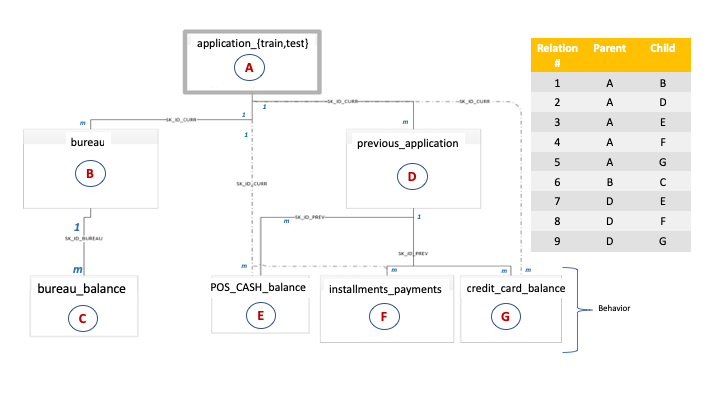

# Load and Sample Data

In [3]:
from quilt.data.avare import homecredit

In [4]:
frames = {}
size = 5000
factor = 2
rand=1


for key, val in homecredit._items():
    
    frames[key] = val().copy(deep=True)
    
    if ( key == 'previous_application' ):
        dropcols = ['RATE_INTEREST_PRIVILEGED','RATE_INTEREST_PRIMARY']
        frames[key].drop(dropcols, axis=1, inplace=True)
    
    frames[key].dropna(inplace=True)
    
    #print(len(frames[key]))

    if (key == 'application_train' ):
        frames[key] = frames[key].sample(n=size, random_state=rand)
    else: 
        frames[key] = frames[key].sample(n=size*factor, random_state=rand)

    #print(len(frames[key]))
                           
popped = frames['application_train'].pop('TARGET')    

10000
5000
10000
10000
10000
10000
10000


# Overide Panda Inferred Data Types

Although types are inferred by Panda, we need to validate them, since the inferred ones may not be what you expect. We could avoid this problem by including the types as an argument in the read_csv, but - we did not use read_csv() with Quilt.

It turns out that some of the columns in the [Metadata file](data/HomeCredit_columns_description.txt) do not match, one-to-one, with the columns in the data files.

To handle the mismatch, we perform a bit of housekeeping.

In [5]:
# read metadata file , white space in the some colums ...bump...removed manually
description = pd.read_excel('data/HomeCredit_columns_description.xlsx', sheet_name='Sheet1',usecols=[2,3,4])

# rename types in data description to python types
python_cat_dtype = 'object'
python_num_dtype = 'float64'
description.replace('categorical', python_cat_dtype, inplace=True)
description.replace('numerical', python_num_dtype, inplace=True)

merged = {}
for table in frames.keys():
    
    df = frames[table]
    
    # select types for the target cols
    types = description[(description.Table == table)]
    # select the target columns 
    targetcols = pd.DataFrame(df.columns, columns=['Row'])
   
    # perform join:
    targetcols = targetcols.merge(types, how='left')

    merged[table] = targetcols
    
    # batch overide inferred categoricals 
    catcols = targetcols.loc[(targetcols.Type == python_cat_dtype),'Row'].values.tolist()
    df[catcols] = df[catcols].astype(python_cat_dtype)

    # batch overide inferred numericals
    numcols = targetcols.loc[(targetcols.Type == python_num_dtype),'Row'].values.tolist()
    df[numcols] = df[numcols].astype(python_num_dtype)

    

In [217]:
#frames['application_train'].SK_ID_CURR = frames['application_train'].SK_ID_CURR.astype('category')

#frames['bureau'].SK_ID_CURR = frames['bureau'].SK_ID_CURR.astype('category')
#frames['bureau'].SK_ID_BUREAU = frames['bureau'].SK_ID_BUREAU.astype('category')

#frames['bureau_balance'].SK_ID_CURR = frames['bureau_balance'].SK_ID_BUREAU.astype('category')

#frames['previous_application'].SK_ID_CURR = frames['previous_application'].SK_ID_CURR.astype('category')
#frames['previous_application'].SK_ID_PREV = frames['previous_application'].SK_ID_PREV.astype('category')

/Users/stewarta/repos/data-prep-visualization/data-prep-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


# Entity Set and Entities

## Entity Set

[Entity Set](https://docs.featuretools.com/generated/featuretools.EntitySet.entity_from_dataframe.html#featuretools-entityset-entity-from-dataframe) represents a  set of database tables, as shown in the image above. 


In [223]:
# create an entity set
es = ft.EntitySet(id="application_entity_set")

## helper function to create a dictionary of column: data type mappings
# df has two columns: Row(column name) Type (a python dtype)
def as_dict_featuretools(df):
 
    categorical = 'object'
    numeric = 'float64'

    # rename types
    df.replace(numeric, ft.variable_types.Numeric, inplace=True)
    df.replace(categorical, ft.variable_types.Categorical, inplace=True)

    # convert to dict
    tuples = dict([*zip(df.Row.values, df.Type.values)])
    return tuples

## (A) : Application Entity

In [224]:
table_name = 'application_train'
index = 'SK_ID_CURR'

variable_types = as_dict_featuretools(merged[table_name])

es = es.entity_from_dataframe(dataframe=frames[table_name],
                              entity_id=table_name,
                              index=index,
                              variable_types = variable_types)

## (B) : Bureau  Entity

In [225]:
table_name = 'bureau'
index = 'SK_ID_BUREAU'
variable_types = as_dict_featuretools(merged[table_name])
es = es.entity_from_dataframe(dataframe=frames[table_name],
                              entity_id=table_name,
                              index=index,
                              variable_types=variable_types)


In [227]:
frames['bureau'].head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
273570,190381,5058520,Closed,currency 1,-1898.0,0.0,-1716.0,-1716.0,0.0,0.0,36162.27,0.0,0.0,0.0,Consumer credit,-753.0,14400.00
130127,219289,6570959,Closed,currency 1,-1006.0,0.0,-945.0,-945.0,0.0,0.0,565326.63,0.0,0.0,0.0,Consumer credit,-945.0,0.00
784230,318510,6088973,Closed,currency 1,-397.0,0.0,-32.0,-32.0,0.0,0.0,187092.00,0.0,0.0,0.0,Consumer credit,-32.0,45629.64
1631089,298111,6693169,Closed,currency 1,-1063.0,0.0,-940.0,-1002.0,0.0,0.0,33615.00,0.0,0.0,0.0,Consumer credit,-1001.0,0.00
1181103,161713,5522443,Closed,currency 1,-1477.0,0.0,-1265.0,-1293.0,0.0,0.0,79228.80,0.0,0.0,0.0,Consumer credit,-1293.0,23382.00


## (C) : Bureau Balance Entity

In [157]:
frames['bureau_balance'].head()

,INDEX,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
4044793,0,5897855.0,-53.0,X
22812152,1,5992461.0,-83.0,0
25741451,2,6112224.0,-61.0,0
24716366,3,5552491.0,-61.0,X
899375,4,6591883.0,-29.0,C


In [174]:
table_name = 'bureau_balance'
index = 'INDEX'

variable_types = as_dict_featuretools(merged[table_name])
es = es.entity_from_dataframe(dataframe=frames[table_name],
                              entity_id=table_name,
                              index=index,
                              make_index=True,
                              variable_types=variable_types)

print(len(variable_types))

4


In [175]:
table_name = 'previous_application'
index = 'SK_ID_PREV'

variable_types = as_dict_featuretools(merged[table_name])
es = es.entity_from_dataframe(dataframe=frames[table_name],
                              entity_id=table_name,
                              index=index,
                              variable_types=variable_types)

print(len(variable_types))

35


# Parent-Child Relations

In [228]:
## Relation A-B
new_relationship = ft.Relationship(es["application_train"]["SK_ID_CURR"],
                                    es["bureau"]["SK_ID_CURR"])
es = es.add_relationship(new_relationship)

## Relation B-C
#new_relationship = ft.Relationship(es["bureau"]["SK_ID_BUREAU"],
#es["bureau_balance"]["INDEX"])


2019-05-03 04:44:47,596 featuretools.entityset - WARNING    Not adding duplicate relationship: <Relationship: bureau.SK_ID_CURR -> application_train.SK_ID_CURR>


In [229]:
%time feature_matrix, feature_defs = ft.dfs(entityset=es, target_entity="application_train")

CPU times: user 8.86 s, sys: 55.8 ms, total: 8.92 s
Wall time: 8.92 s


In [230]:
feature_matrix

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,...,STD(bureau.CNT_CREDIT_PROLONG),STD(bureau.AMT_CREDIT_SUM),STD(bureau.AMT_CREDIT_SUM_DEBT),STD(bureau.AMT_CREDIT_SUM_LIMIT),STD(bureau.AMT_CREDIT_SUM_OVERDUE),STD(bureau.DAYS_CREDIT_UPDATE),STD(bureau.AMT_ANNUITY),MAX(bureau.DAYS_CREDIT),MAX(bureau.CREDIT_DAY_OVERDUE),MAX(bureau.DAYS_CREDIT_ENDDATE),MAX(bureau.DAYS_ENDDATE_FACT),MAX(bureau.AMT_CREDIT_MAX_OVERDUE),MAX(bureau.CNT_CREDIT_PROLONG),MAX(bureau.AMT_CREDIT_SUM),MAX(bureau.AMT_CREDIT_SUM_DEBT),MAX(bureau.AMT_CREDIT_SUM_LIMIT),MAX(bureau.AMT_CREDIT_SUM_OVERDUE),MAX(bureau.DAYS_CREDIT_UPDATE),MAX(bureau.AMT_ANNUITY),SKEW(bureau.DAYS_CREDIT),SKEW(bureau.CREDIT_DAY_OVERDUE),SKEW(bureau.DAYS_CREDIT_ENDDATE),SKEW(bureau.DAYS_ENDDATE_FACT),SKEW(bureau.AMT_CREDIT_MAX_OVERDUE),SKEW(bureau.CNT_CREDIT_PROLONG),SKEW(bureau.AMT_CREDIT_SUM),SKEW(bureau.AMT_CREDIT_SUM_DEBT),SKEW(bureau.AMT_CREDIT_SUM_LIMIT),SKEW(bureau.AMT_CREDIT_SUM_OVERDUE),SKEW(bureau.DAYS_CREDIT_UPDATE),SKEW(bureau.AMT_ANNUITY),MIN(bureau.DAYS_CREDIT),MIN(bureau.CREDIT_DAY_OVERDUE),MIN(bureau.DAYS_CREDIT_ENDDATE),MIN(bureau.DAYS_ENDDATE_FACT),MIN(bureau.AMT_CREDIT_MAX_OVERDUE),MIN(bureau.CNT_CREDIT_PROLONG),MIN(bureau.AMT_CREDIT_SUM),MIN(bureau.AMT_CREDIT_SUM_DEBT),MIN(bureau.AMT_CREDIT_SUM_LIMIT),MIN(bureau.AMT_CREDIT_SUM_OVERDUE),MIN(bureau.DAYS_CREDIT_UPDATE),MIN(bureau.AMT_ANNUITY),MEAN(bureau.DAYS_CREDIT),MEAN(bureau.CREDIT_DAY_OVERDUE),MEAN(bureau.DAYS_CREDIT_ENDDATE),MEAN(bureau.DAYS_ENDDATE_FACT),MEAN(bureau.AMT_CREDIT_MAX_OVERDUE),MEAN(bureau.CNT_CREDIT_PROLONG),MEAN(bureau.AMT_CREDIT_SUM),MEAN(bureau.AMT_CREDIT_SUM_DEBT),MEAN(bureau.AMT_CREDIT_SUM_LIMIT),MEAN(bureau.AMT_CREDIT_SUM_OVERDUE),MEAN(bureau.DAYS_CREDIT_UPDATE),MEAN(bureau.AMT_ANNUITY),COUNT(bureau),NUM_UNIQUE(bureau.CREDIT_ACTIVE),NUM_UNIQUE(bureau.CREDIT_CURRENCY),NUM_UNIQUE(bureau.CREDIT_TYPE),MODE(bureau.CREDIT_ACTIVE),MODE(bureau.CREDIT_CURRENCY),MODE(bureau.CREDIT_TYPE)
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100145,Cash loans,F,Y,Y,1.0,202500.0,260725.5,16789.5,198000.0,Family,Working,Secondary / secondary special,Separated,House / apartment,0.018850,-16282.0,-4375.0,-762.0,-1494.0,8.0,1,1,0,1,0,0,Laborers,2.0,2,2,TUESDAY,11.0,0,0,0,0,0,0,Self-employed,0.647045,0.746486,0.739412,0.0928,0.1000,0.9801,0.7280,0.0463,0.0000,0.2069,0.1667,0.2083,0.0437,0.0756,0.0903,0.0000,0.0000,0.0945,0.1038,0.9801,0.7387,0.0467,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
100190,Cash loans,M,Y,N,0.0,162000.0,263686.5,24781.5,238500.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.022625,-13972.0,-4472.0,-464.0,-4529.0,3.0,1,1,0,1,1,0,Laborers,2.0,2

Run time on all data:

CPU times: user 27min 32s, sys: 32.1 s, total: 28min 4s
Wall time: 29min 56s

Problem: must handle missing data in order for features to be computed!!

If we impute missing data for real numbers - we could introduce bias 

In [231]:
feature_defs

[<Feature: NAME_CONTRACT_TYPE>,
 <Feature: CODE_GENDER>,
 <Feature: FLAG_OWN_CAR>,
 <Feature: FLAG_OWN_REALTY>,
 <Feature: CNT_CHILDREN>,
 <Feature: AMT_INCOME_TOTAL>,
 <Feature: AMT_CREDIT>,
 <Feature: AMT_ANNUITY>,
 <Feature: AMT_GOODS_PRICE>,
 <Feature: NAME_TYPE_SUITE>,
 <Feature: NAME_INCOME_TYPE>,
 <Feature: NAME_EDUCATION_TYPE>,
 <Feature: NAME_FAMILY_STATUS>,
 <Feature: NAME_HOUSING_TYPE>,
 <Feature: REGION_POPULATION_RELATIVE>,
 <Feature: DAYS_BIRTH>,
 <Feature: DAYS_EMPLOYED>,
 <Feature: DAYS_REGISTRATION>,
 <Feature: DAYS_ID_PUBLISH>,
 <Feature: OWN_CAR_AGE>,
 <Feature: FLAG_MOBIL>,
 <Feature: FLAG_EMP_PHONE>,
 <Feature: FLAG_WORK_PHONE>,
 <Feature: FLAG_CONT_MOBILE>,
 <Feature: FLAG_PHONE>,
 <Feature: FLAG_EMAIL>,
 <Feature: OCCUPATION_TYPE>,
 <Feature: CNT_FAM_MEMBERS>,
 <Feature: REGION_RATING_CLIENT>,
 <Feature: REGION_RATING_CLIENT_W_CITY>,
 <Feature: WEEKDAY_APPR_PROCESS_START>,
 <Feature: HOUR_APPR_PROCESS_START>,
 <Feature: REG_REGION_NOT_LIVE_REGION>,
 <Feature: REG

In [ ]:
es.plot

In [308]:
homecredit.bureau_balance().head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,INDEX
0,5715448,0,C,0
1,5715448,-1,C,1
2,5715448,-2,C,2
3,5715448,-3,C,3
4,5715448,-4,C,4


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C
8,5715448,-8,C
9,5715448,-9,0


In [397]:
# reset
table_name = 'bureau_balance'
#frames[table_name].reset_index()
#frames[table_name].drop('INDEX', axis=1, inplace=True)
frames[table_name]

,INDEX,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,0,5715448,0,C
1,1,5715448,-1,C
2,2,5715448,-2,C
3,3,5715448,-3,C
4,4,5715448,-4,C
5,5,5715448,-5,C
6,6,5715448,-6,C
7,7,5715448,-7,C
8,8,5715448,-8,C
9,9,5715448,-9,0


In [393]:
# reset
table_name = 'bureau_balance'
homecredit[table_name]().reset_index()
homecredit[table_name]().drop('INDEX', axis=1, inplace=True)
homecredit[table_name]()

KeyError: "['INDEX'] not found in axis"

In [396]:
table_name = 'bureau_balance'
homecredit[table_name]()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C
8,5715448,-8,C
9,5715448,-9,0


In [ ]:
data = ft.demo.load_mock_customer()
data['transactions'].head()